***STAGE 2: DATA PRE-PROCESSING***

# **1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

In [2]:
%matplotlib inline

In [3]:
import matplotlib

print(matplotlib.__version__)
print(sns.__version__)
print(pd.__version__)

3.5.2
0.11.2
1.3.4


# **2. Load Data** <br>
Data yang digunakan yaitu [Used Car Auction Prices](https://www.kaggle.com/datasets/tunguz/used-car-auction-prices) dari kaggle.com.


In [4]:
df = pd.read_csv('car_prices.csv', on_bad_lines='skip')

# **3. Data Pre-processing** <br>

## 3.1. Handling Duplicated Data

In [5]:
df.duplicated().sum()

0

Tidak ada data duplikat.

## 3.2. Handling Missing Values

### 3.2.1 Drop Missing Values

In [6]:
mv = df.isnull().sum()
tmv = df.isnull().count()

pmv = mv*100/tmv

mdf = pd.concat([mv, pmv], axis=1)
mdf.columns = ['Missing Value Total', 'Missing Value Percentage (%)']
mdf.reset_index(inplace=True)
# mdf

In [7]:
col_mv = mdf[mdf['Missing Value Percentage (%)'] < 2.5]['index'] # kolom dengan missing value < 2.5 akan kita drop barisnya
# col_mv

In [8]:
# Setelah drop missing value dari kolom yang persentase missing value < 2.5 %
cols = col_mv.values
for i in cols:
  df = df[~(df[i].isnull())]
df.isna().sum()

year                0
make                0
model               0
trim                0
body                0
transmission    61324
vin                 0
state               0
condition           0
odometer            0
color               0
interior            0
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

In [9]:
# df.shape

### 3.2.2 Fill Missing Value in Transmission Column

In [10]:
# before filling missing value
df['transmission'].isnull().sum()

61324

In [11]:
# after filling missing value
df['transmission'] = df['transmission'].fillna(df['transmission'].mode()[0])
df['transmission'].isnull().sum()

0

In [12]:
# df.info()

## 3.3. Recategorization High Cardinality in Categorical Features

### 3.3.1 Color

In [13]:
# mengganti nilai - menjadi unknown pada kolom color
df.color = df.color.replace('—', 'unknown')

In [14]:
color_grouped = df.groupby('color').agg({'sellingprice':'count'}).reset_index()
color_grouped['Percentage']=color_grouped['sellingprice']*100/color_grouped.sellingprice.sum()
# color_grouped.sort_values('sellingprice', ascending=False).reset_index(drop=True)

melihat persentase dibawah 10 yang kecil, oleh karena itu beberapa warna yang di rasa sama akan digabungkan.

In [15]:
def color_category(x): 
  if x in ['black','charcoal','unknown']: 
    color = 'black'
  elif x in ['off-white', 'white']:
    color = 'white'
  elif x == 'silver':
    color = 'silver'
  elif x == 'gray':
    color = 'gray'
  elif x in ['blue', 'turqoise']:
    color = 'blue'
  elif x in ['burgundy', 'red', 'purple']:
    color = 'red'
  elif x in ['beige','brown']:
    color = 'brown'
  elif x == 'green':
    color = 'green'
  elif x in ['gold','yellow']:
    color = 'gold'
  elif x == 'pink':
    color = 'pink'
  else:
    color= 'orange'
  return color

In [16]:
# Membuat kolom baru yaitu kolom color_new menggunakan fungsi color_category
df['color_new'] = df['color'].apply(lambda x: color_category(x))

In [17]:
# Drop kolom color
df = df.drop(columns='color')

### 3.3.2 Interior

In [18]:
# Mengganti nilai - menjadi unknown pada kolom interior
df.interior = df.interior.replace('—', 'unknown')

In [19]:
# membuat kolom baru yaitu kolom interior_new menggunakan fungsi interior_category
df['interior_new'] = df['interior'].apply(lambda x: color_category(x))

In [20]:
# Drop kolom interior
df = df.drop(columns='interior')

### 3.3.3 Model

In [21]:
df['model'] = df.model.str.lower()

## 3.4. Feature Transformation <br>
Log Transformation pada feature odometer. Kami melakukan transoformasi terlebih dulu sebelum melakukan handling outlier. Jika kita melakukan handling outlier terlebih dulu, maka kemungkinan data yang akan dibuang lebih banyak. Oleh karena itu, kami melakukan log transformation terlebih dulu dengan harapan data semakin terdistribusi dengan normal sehingga data yang terindikasi outlier lebih sedikit.

### 3.4.1 Transformasi dengan Pangkat 1/3

In [22]:
df['odometer_pow'] = df['odometer'].apply(lambda x : x**(1/3))
print('Skew value:', df['odometer_pow'].skew())

Skew value: 0.0656155379397687


### 3.4.2 PowerTransformer <br>
[PowerTransformer](https://medium.com/towards-data-science/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94)

In [23]:
# Transformasi dengan PowerTransformer
from sklearn.preprocessing import PowerTransformer
df['odometer_pt'] = PowerTransformer().fit_transform(df['odometer'].values.reshape(len(df), 1))
print('Skew value:', df['odometer_pt'].skew())

Skew value: 0.012277514291040147


Berdasarkan nilai skew, kami memilih menggunakan hasil transformasi dari PowerTransformer (odometer_pt)

In [24]:
# Drop kolom odometer_pow
df = df.drop(columns='odometer_pow')

## 3.5. Handling Outliers <br>
Handling outlier dilakukan pada kolom `odometer_pt` dan `sellingprice`.

In [25]:
# Boxplot sebelum handling outlier
cols = ['odometer_pt', 'sellingprice']

# plt.figure(figsize=(9,6))
# for i in range(len(cols)):
#     plt.subplot(1, len(cols), i+1)
#     sns.boxplot(y = df[cols[i]], orient = 'v')
#     plt.tight_layout()

rows_before_filt = len(df)
print('Jumlah Baris sebelum filter:', rows_before_filt, '\n')

Jumlah Baris sebelum filter: 533660 



In [26]:
# Handling outlier dengan z-score
cols = ['odometer_pt', 'sellingprice']

filtered_entries = np.array([True] * len(df))

for col in cols:
    zscore = abs(stats.zscore(df[col]))                       # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries        # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries]                                     # filter, cuma ambil yang z-scorenya dibawah 3

# Total baris yang dibuang
rows_after_filt = len(df)
diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
print(f'Jumlah baris setelah memfilter outlier: {len(df)}')
print(f'Persentase outlier yang dibuang:', diff)

Jumlah baris setelah memfilter outlier: 525058
Persentase outlier yang dibuang: 1.61


## 3.6. Feature Extraction <br>


### 3.6.1 New Column: Car Age

In [27]:
# Format awal kolom saledate
print('format saledate original:\n', df.saledate[0])

# Transform kolom saledate
df['saledate'] = df['saledate'].apply(lambda x:re.search('(\w+\s\d{2}\s\d{4})',x).group(1))
df['saledate'] = pd.to_datetime(df['saledate'], format='%b %d %Y')

format saledate original:
 Tue Dec 16 2014 12:30:00 GMT-0800 (PST)


In [28]:
# Buat kolom baru saledate_year
df['saledate_year'] = df['saledate'].dt.year

# Buat kolom baru Car Age (Car age = saledate_year - year <tahun produksi mobil>)
df['car_age'] = df['saledate_year'] - df['year']
print('Unique value car age:', df['car_age'].unique())

Unique value car age: [-1  1  0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 17 20 22 23
 21 24 25]


In [29]:
# Drop baris yang mengandung nilai < 0 pada kolom Car Age (terdapat 141 baris yg car age < 0)
df = df[df['car_age'] >= 0]

# Drop kolom saledate dan year
df = df.drop(columns=['saledate', 'year'])

Skew value: 0.005011404205303489


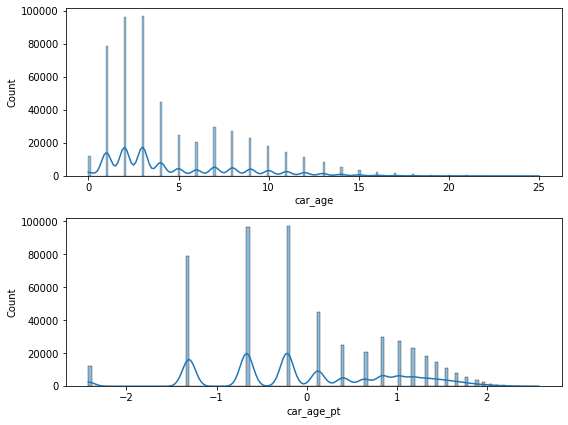

In [30]:
# PowerTransform Car Age
df['car_age_pt'] = PowerTransformer().fit_transform(df['car_age'].values.reshape(len(df), 1))
print('Skew value:', df['car_age_pt'].skew())

# KDE car_age
cols = ['car_age', 'car_age_pt']
plt.figure(figsize=(8, 6))
for i in range(len(cols)):
  plt.subplot(len(cols), 1, i+1)
  sns.histplot(data=df, x=df[cols[i]], kde=True)
  plt.tight_layout()

In [31]:
# Drop car age
df = df.drop(columns='car_age')

## 3.7. Feature Selection <br>
Feature yang akan digunakan dalam membangun model adalah:
- **Categorical**: color_new, interior_new, model_new, transmission
- **Numerical**: car_age_pt, odometer_pt, condition.
- Kolom yang **di-drop**:
  - year -> kolom ini digantikan dengan kolom car_age
  - trim, vin -> karena high cardinality
  - make, body -> unique terhadap model
  - state -> karena KDE-nya sama-sama saja (?)
  - seller, mmr -> high cardinality
  - saledate -> high cardinality

KOLOM YANG PERLU DISTANDARISASI SETELAH SPLITTING:
car_age_pt, odometer_pt, condition

Karena terdapat banyak sekali data unique pada model, maka hanya digunakan 30 model teratas.

In [32]:
# Feature yang dipilih untuk memprediksi sellingprice
df = df[['color_new', 'interior_new', 'model', 'transmission',
         'car_age_pt', 'odometer_pt', 'condition', 'sellingprice']]

g_m = df.groupby('model')['transmission'].count()
g_m.sort_values(ascending=False, inplace=True)
g_m = g_m.reset_index()
g_m = g_m.iloc[:30, 0]

model_new = [i for i in g_m]

df = df[df['model'].isin(model_new)]
df.shape

(231575, 8)

## 3.8. Feature encoding

### 3.8.1 Label Encoding

In [33]:
# Label encoding -> kolom transmission
mapping_trans = {
    'automatic' : 0,
    'manual' : 1
}

df['transmission'] = df['transmission'].map(mapping_trans)

### 3.8.2 One Hot Encoding

In [34]:
# OHE -> kolom color_new, interior_new, make_new, body_new

cols_OHE = ['color_new', 'interior_new', 'model']

for i in cols_OHE:
    onehots = pd.get_dummies(df[i], prefix=i, drop_first=True)  # drop_first=True utk menghindari multicollinearity
    df = df.merge(onehots, how='outer', right_index = True, left_index = True)

### 3.8.3 Drop the columns that have been done Feature Encoding <br>
Kolom yang telah dilakukan OHE akan di-drop

In [35]:
df = df.drop(columns=cols_OHE)

## 3.9. All Features
- [split_data](https://towardsdatascience.com/how-to-split-a-dataset-into-training-and-testing-sets-b146b1649830)
- [Using StandarScaler() after split data](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data)
- https://scikit-learn.org/stable/common_pitfalls.html

In [36]:
df.head(2)

,transmission,car_age_pt,odometer_pt,condition,sellingprice,color_new_blue,color_new_brown,color_new_gold,color_new_gray,color_new_green,...,model_jetta,model_malibu,model_maxima,model_mustang,model_rogue,model_sentra,model_silverado 1500,model_sonata,model_taurus,model_town and country
2,0,-1.306077,-2.604439,4.5,30000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,-2.422727,-0.673565,2.0,9800,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df.columns

Index(['transmission', 'car_age_pt', 'odometer_pt', 'condition',
       'sellingprice', 'color_new_blue', 'color_new_brown', 'color_new_gold',
       'color_new_gray', 'color_new_green', 'color_new_orange',
       'color_new_pink', 'color_new_red', 'color_new_silver',
       'color_new_white', 'interior_new_blue', 'interior_new_brown',
       'interior_new_gold', 'interior_new_gray', 'interior_new_green',
       'interior_new_orange', 'interior_new_red', 'interior_new_silver',
       'interior_new_white', 'model_accord', 'model_altima', 'model_c-class',
       'model_camry', 'model_civic', 'model_corolla', 'model_cruze',
       'model_edge', 'model_elantra', 'model_equinox', 'model_escape',
       'model_explorer', 'model_f-150', 'model_focus', 'model_fusion',
       'model_g sedan', 'model_grand caravan', 'model_grand cherokee',
       'model_impala', 'model_jetta', 'model_malibu', 'model_maxima',
       'model_mustang', 'model_rogue', 'model_sentra', 'model_silverado 1500',
       'm

In [38]:
df.shape

(231575, 53)

In [39]:
# Split Dataset
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.3, random_state=25)

print('Total training data:', training_data.shape[0])
print('Total testing data:', testing_data.shape[0])

Total training data: 162102
Total testing data: 69473


In [40]:
# Save to csv
training_data.to_csv('train_data.csv', index=False)
testing_data.to_csv('test_data.csv', index=False)

In [41]:
# Splitting data

X_train = training_data.drop(columns=['sellingprice'])
y_train =  training_data['sellingprice']

X_test = testing_data.drop(columns=['sellingprice'])
y_test = testing_data['sellingprice']

In [42]:
# Standarisasi Features
from sklearn.preprocessing import StandardScaler

# OPSI 1: Langsung semua distandarisasi pakai 1 Standarscaler saja
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform (X_test)

In [43]:
# # Fitting simple linear regression to the Training Set
from sklearn.linear_model import LogisticRegression

regressor = LogisticRegression()
regressor.fit(X_train, y_train)

C:\Users\julda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [44]:
# Model Evaluation Train
y_pred_train = regressor.predict(X_train)
# Model Evaluation Test
y_pred_test = regressor.predict(X_test)

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print('Train Score')
print(f'MAE : {mean_absolute_error(y_train, y_pred_train)}')
print(f'RMSE : {mean_squared_error(y_train, y_pred_train, squared=False)}')
print(f'R2 Score : {r2_score(y_train, y_pred_train)}')
print('===========================')
print('Test Score')
print(f'MAE : {mean_absolute_error(y_test, y_pred_test)}')
print(f'RMSE : {mean_squared_error(y_test, y_pred_test, squared=False)}')
print(f'R2 Score : {r2_score(y_test, y_pred_test)}')

Train Score
MAE : 1733.6730577044084
RMSE : 2738.443801376037
R2 Score : 0.8439193300229189
Test Score
MAE : 1753.331049472457
RMSE : 2775.913737368402
R2 Score : 0.8402821865013836


In [ ]:
from sklearn.model_selection import GridSearchCV

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['none','l1','l2']
c_val = [100,10,1,0.1,0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_val)

grid_search = GridSearchCV(regressor, grid, cv=5, scoring='r2')
grid_search.fit(X_train,y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\julda\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\julda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [ ]:
y_pred_tr = grid_search.predict(X_train)
y_pred_ts = grid_search.predict(X_test)

In [48]:
#print('Train Score')
#print(f'MAE : {mean_absolute_error(y_train, y_pred_tr)}')
#print(f'RMSE : {mean_squared_error(y_train, y_pred_tr, squared=False)}')
#print(f'R2 Score : {r2_score(y_train, y_pred_tr)}')
#print('===========================')
#print('Test Score')
#print(f'MAE : {mean_absolute_error(y_test, y_pred_ts)}')
#print(f'RMSE : {mean_squared_error(y_test, y_pred_ts, squared=False)}')
#print(f'R2 Score : {r2_score(y_test, y_pred_ts)}')